In [1]:
import cv2
import numpy as np

from matplotlib import pyplot as plt

In [6]:
frame = cv2.imread('image.jpg')

In [ ]:
# Modify Image

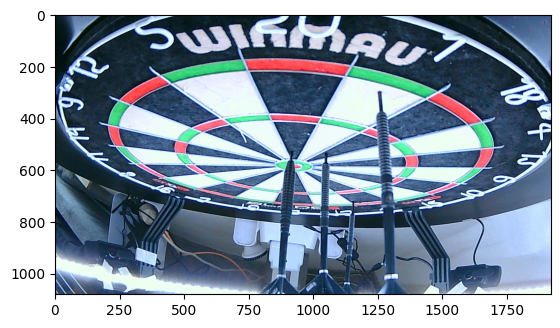

In [5]:
image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.show()